# Exploring ROOT Tuples
This notebook will use the examples given by Dan in his notebook and play around and look at some other variables. This could be considered 'having a play'. The first part of this is to ensure we are using the lb-dog kernel and then import all the necessary libaries.

In [1]:
import uproot as up
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import os
import sys
import copy
from loadCutPlot import *

In [31]:
print(up.__version__)

0.1.2


## Reading in the Tuple
Firstly we need to read in the tuple. We define the fileLoc variable to be the absolute path to this file. Maybe this is less redundant but resolves some complexities for now.

In [2]:
fName="/disk/moose/lhcb/djdt/Lb2L1520mueTuples/MC/2016MD/100FilesCheck/job185-CombDVntuple-15314000-MC2016MD_100F-pKmue-MC.root"

Now we can open the file in the standard way. Note that using the with keyword is reccomended on the UpRoot documentation. 

In [3]:
with up.open(fName) as f:
    print(f.keys())

['DTT1520me;1', 'DTT1520me/DecayTree;1']


Now we look at some different branches within the DTT1520me/DecayTree tree. That is all the keys associated with said tree.

In [4]:
with up.open(fName + ":DTT1520me/DecayTree") as f:
    # print(f.keys())
    print(f.show())
    # It is better to use f.show() as this provides some *much needed* formatting.

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
Lb_MINIP             | double                   | AsDtype('>f8')
Lb_MINIPCHI2         | double                   | AsDtype('>f8')
Lb_MINIPNEXTBEST     | double                   | AsDtype('>f8')
Lb_MINIPCHI2NEXTBEST | double                   | AsDtype('>f8')
Lb_ENDVERTEX_X       | double                   | AsDtype('>f8')
Lb_ENDVERTEX_Y       | double                   | AsDtype('>f8')
Lb_ENDVERTEX_Z       | double                   | AsDtype('>f8')
Lb_ENDVERTEX_XERR    | double                   | AsDtype('>f8')
Lb_ENDVERTEX_YERR    | double                   | AsDtype('>f8')
Lb_ENDVERTEX_ZERR    | double                   | AsDtype('>f8')
Lb_ENDVERTEX_CHI2    | double                   | AsDtype('>f8')
Lb_ENDVERTEX_NDOF    | int32_t                  | AsDtype('>i4')
Lb_ENDVERTEX_COV_    | float[3][3]              | AsDtype(

Now we can open a particular variables data as either a numpy array or a Pandas dataframe. We elect to use both some of the functions Dan wrote are numpy only but can probably be adapted for use in Pandas.

In [5]:
with up.open(fName + ":DTT1520me/DecayTree") as f:
    eventNum = f["eventNumber"].array(library="pd") # Using 'np' here will give you a numpy version
    
print(eventNum.head(), type(eventNum))

0    4826
1    4826
2    4826
3    4826
4    4826
dtype: uint64 <class 'pandas.core.series.Series'>


As can be seen we have a lovely Pandas series object with the index column and then the event number in the next column. You should probably rename the columns in the above just to keep things pretty and tidy. 

### Reading Multiple Arrays at Once
We can also read in multiple variables or arrays at once, which is significantly faster and easier than doing it one at a time. An example is given below where the eventNumber, runNumber and arbitrarily the PVNTRACKS are read in.

In [6]:
with up.open(fName + ":DTT1520me/DecayTree") as f:
    df = f.arrays(["eventNumber", "runNumber", "PVNTRACKS"], library="pd")
    # You can also use Wildcards to call in particular sets of varialbles the example is commented out below
    # allPT=f.arrays(filter_name="*_PT",library="pd")
    
print(df.head())

                eventNumber  runNumber  PVNTRACKS
entry subentry                                   
0     0                4826   14469097       91.0
      1                4826   14469097       10.0
1     0                4826   14469097       91.0
      1                4826   14469097       10.0
2     0                4826   14469097       91.0


Now consider doing calculations with Pandas maybe a little more strenuous but I love the organisation of the dataframes. 

In [7]:
with up.open(fName + ":DTT1520me/DecayTree") as f:
    df = f.arrays(["Lb_PX","Lb_PY","Lb_PZ", 'Lb_P'], library="pd")
    # Let us check that the given momentum is indeed what we expect
    df['Momentum'] = np.sqrt(df['Lb_PX']**2 + df['Lb_PY']**2 + df['Lb_PZ']**2)
    
print(df.head())

    Lb_PX    Lb_PY     Lb_PZ          Lb_P      Momentum
0 -524.80  1096.39  35699.10  35719.787610  35719.787610
1 -524.83  1096.45  35699.10  35719.789892  35719.789892
2  583.36   826.95  32911.48  32927.035563  32927.035563
3  429.59   288.68  35238.88  35242.680763  35242.680763
4 -524.80  1096.39  35699.10  35719.787610  35719.787610


These results seem consistent which is pretty handy.

In [8]:
with up.open(fName + ":DTT1520me/DecayTree") as f:
    df = f.arrays(["Lb_ENDVERTEX_X", "Lb_ENDVERTEX_Y", "Lb_ENDVERTEX_Z"], library="pd")
    # df = f.arrays(filter_name="Lb_ENDVERTEX_*", library="pd")
    
print(df.head())

   Lb_ENDVERTEX_X  Lb_ENDVERTEX_Y  Lb_ENDVERTEX_Z
0          0.8142         -0.0995         41.0646
1          0.8143         -0.0997         41.0650
2          0.8226         -0.0889         41.1102
3          0.8148         -0.1026         41.0596
4          0.8142         -0.0995         41.0646


Lets plot that initial interaction position as a 3-D graph.

In [9]:
import seaborn as sns
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
sns.set(style='darkgrid')

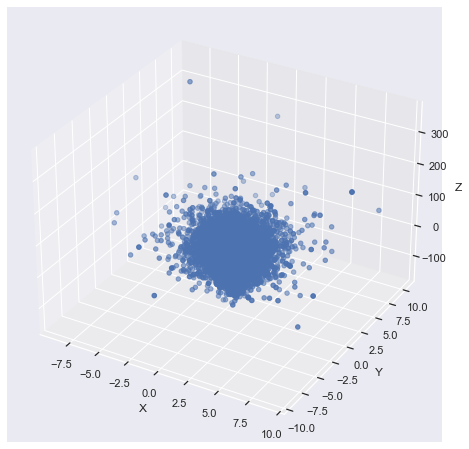

In [10]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection = '3d')

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.scatter(df['Lb_ENDVERTEX_X'], df['Lb_ENDVERTEX_Y'], df['Lb_ENDVERTEX_Z'])

plt.show()

This is great! About what we would expect. The most probable interaction position appears to be clustered around (0, 0, 0) which is what you would expect, the VELO should be at the interaction position. I am not sure what the units are though.

Now lets plot all variations between the momentum along each axis and see if anything interesting crops up.

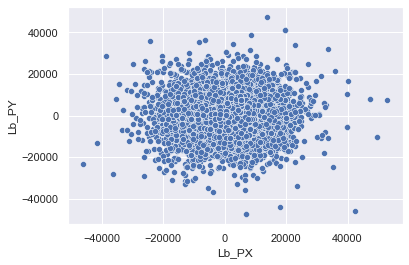

count    33953.000000
mean        66.996267
std       6406.097107
min     -46066.080000
25%      -3688.550000
50%         52.370000
75%       3821.000000
max      52896.800000
Name: Lb_PX, dtype: float64
              Lb_PX         Lb_PY         Lb_PZ
count  33953.000000  33953.000000  3.395300e+04
mean      66.996267     64.700623  1.114500e+05
std     6406.097107   6165.005301  8.210595e+04
min   -46066.080000 -47562.740000  1.697720e+04
25%    -3688.550000  -3510.300000  5.963918e+04
50%       52.370000     70.600000  8.680885e+04
75%     3821.000000   3621.890000  1.357807e+05
max    52896.800000  47533.790000  1.246234e+06


In [11]:
with up.open(fName + ":DTT1520me/DecayTree") as f:
    df = f.arrays(["Lb_PX", "Lb_PY", "Lb_PZ", "Lb_PT", "Lb_M"], library="pd")

sns.scatterplot(data=df, x="Lb_PX", y="Lb_PY")
plt.show()

print(df["Lb_PX"].describe())
# Remember you can generate summary statistics for a single or combination or separately multiple columns using describe.
print(df[["Lb_PX", "Lb_PY", "Lb_PZ"]].describe())

In [42]:
plt.scatter(df["Lb_PX"], df["Lb_PZ"], s=20, c=df["Lb_M"], cmap='Greens')
cbar = plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>

In [43]:
!pip install grpcio==1.34.0
!pip install keras

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [44]:
#import tensorflow as tf
#from keras.models import Sequential
#from keras.layers import Dropout, Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, MaxPool2D

## Have a look at more variables
Lets have a look at whatever this weird variable is mostly just to play around

In [45]:
pkmueDecayDescriptor=r"$\Lambda_b^0 \rightarrow \Lambda (1520) \mu e$"
loadNTuple(fileLoc=fName, treeID="DTT1520me/DecayTree", datasetName="MC", decayName=pkmueDecayDescriptor+"Simulation", MCDataset=True)

In [46]:
currMode[0]="MC"
LbDataGet("Lb_M") 
# The above is a numpy array now no more pandas, big sad

array([5678.79881665, 5606.68261987, 5236.47018515, ..., 4805.47021633,
       5338.12701235, 5633.15861662])

In [47]:
%matplotlib notebook
a=create1DHist("Lb_M",plotArgs=(4500,6500,200),blindSignalRegion=False) #plots can be overlaid
create1DHist("Lb_M",TCut=("TM",truthMatching()),plotArgs=a[1],blindSignalRegion=False,overlay=True,plotDecor=plotDecDict(histCol="r"),outputHist=False)

<IPython.core.display.Javascript object>

## Further Plots of Interest
In order to make some more interesting plots of different parameters we look up the meaning of all the variables when using f.show() (above). The link to the list describing the meaning of all of these variasbles are given at this link. 

In [48]:
s = ":DTT1520me/DecayTree"
with up.open(fName + s) as f:
    df = f.arrays(["Lb_P", "K_P", "L1_P", "L2_P"], library="pd")
    
print(df.head())

           Lb_P          K_P          L1_P          L2_P
0  35719.787610  5691.445196  11297.693849  10710.517954
1  35719.789892  5691.445196  11297.693849   8394.575666
2  32927.035563  5691.445196  11297.693849   8394.575666
3  35242.680763  5691.445196  11297.693849  10710.517954
4  35719.787610  8394.575666  11297.693849  10710.517954


In [49]:
df['Delta_P'] = (df['K_P'] + df['L1_P'] + df['L2_P']) - df['Lb_P']
df.head()

,Lb_P,K_P,L1_P,L2_P,Delta_P
0,35719.787610,5691.445196,11297.693849,10710.517954,-8020.130611
1,35719.789892,5691.445196,11297.693849,8394.575666,-10336.075182
2,32927.035563,5691.445196,11297.693849,8394.575666,-7543.320853
3,35242.680763,5691.445196,11297.693849,10710.517954,-7543.023764
4,35719.787610,8394.575666,11297.693849,10710.517954,-5317.000141


In [50]:
import seaborn as sns

sns.jointplot(x=df['L1_P'], y=df['L2_P'], kind="kde")
plt.show()

<IPython.core.display.Javascript object>